In [1]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 



2024-04-22 14:40:50.564627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:40:50.564656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:40:50.565481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 14:40:50.569649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:40:51.113087: W tensorflow/compiler/tf2

In [2]:
import psutil
import GPUtil

def get_gpu_utilization():
    # Get the list of available GPUs
    gpus = GPUtil.getGPUs()
    
    if len(gpus) == 0:
        print("No GPU found.")
        return
    
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  - GPU name: {gpu.name}")
        print(f"  - GPU load: {gpu.load * 100:.2f}%")
        print(f"  - GPU memory total: {gpu.memoryTotal} MB")
        print(f"  - GPU memory used: {gpu.memoryUsed} MB")
        print(f"  - GPU memory free: {gpu.memoryFree} MB")
        print(f"  - GPU memory utilization: {gpu.memoryUtil * 100:.2f}%")
        print()

def main():
    # Print CPU utilization
    print("CPU utilization:", psutil.cpu_percent(interval=1))
    
    # Print GPU utilization
    get_gpu_utilization()

if __name__ == "__main__":
    main()


CPU utilization: 0.0
GPU 0:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 24060.0 MB
  - GPU memory free: 157.0 MB
  - GPU memory utilization: 97.95%

GPU 1:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 944.0 MB
  - GPU memory free: 23273.0 MB
  - GPU memory utilization: 3.84%



In [3]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [4]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
   # verbosity = 3
)

CPU times: user 25 µs, sys: 35 µs, total: 60 µs
Wall time: 63.7 µs


In [5]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [6]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [7]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [8]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [9]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [10]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)



In [13]:
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())



In [14]:
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [15]:
%%time


xtrain = xtrain#[:8000]
ytrain = ytrain#[:8000]

xtest = xtest#[:2000]
ytest = ytest#[:2000]


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [16]:
xtrain.shape

(3392543, 10, 14)

In [17]:
ytrain.shape[-1]

2

In [18]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]), changed dfrom 128
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [19]:
xtrain.shape

(3392543, 10, 14)

In [20]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x77fb90f0d550>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x77fb90ee82d0>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x77fb90f0ee90>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x77fb90eddad0>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x77fb90f2af50>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [21]:
ytrain.shape

(3392543, 2)

In [22]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=2,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 2 Complete [01h 21m 54s]
accuracy_score: 0.9272359971101677

Best accuracy_score So Far: 0.9283051082057476
Total elapsed time: 02h 44m 47s
Hyperparameter tuning took 164.782542570432 minutes to process.


In [23]:
xtrain

<xarray.DataArray (samples: 3392543, timesteps: 10, features: 14)>
array([[[0.60118761, 0.61118434, 0.77767597, ..., 0.48967896,
         0.91740444, 0.54801071],
        [0.60149321, 0.61054747, 0.77849771, ..., 0.48967896,
         0.91763048, 0.54800575],
        [0.60118761, 0.61086591, 0.77849771, ..., 0.49151292,
         0.91776607, 0.54558788],
        ...,
        [0.60118761, 0.610229  , 0.77890875, ..., 0.48692795,
         0.91767568, 0.55163752],
        [0.60118761, 0.60991057, 0.77808668, ..., 0.48784485,
         0.91790172, 0.55284646],
        [0.60149321, 0.60991057, 0.77931979, ..., 0.48967896,
         0.91790172, 0.55284646]],

       [[0.45687963, 0.60123388, 0.07850476, ..., 0.49701494,
         0.93675362, 0.3540108 ],
        [0.46635289, 0.60378149, 0.06904518, ..., 0.49609803,
         0.93657272, 0.36124462],
        [0.48469106, 0.60218943, 0.06739559, ..., 0.49609803,
         0.93666311, 0.3672893 ],
...
        [0.11000401, 0.610469  , 0.80135344, ..., 0.47684081,
         0.94688023, 0.35643859],
        [0.1240737 , 0.6111059 , 0.80217532, ..., 0.48142608,
         0.94688023, 0.36248328],
        [0.13416283, 0.610469  , 0.80299723, ..., 0.49334702,
         0.94755836, 0.36852797]],

       [[0.51647306, 0.59454661, 0.07806719, ..., 0.49884904,
         0.94335396, 0.37090621],
        [0.52258662, 0.59518338, 0.05712803, ..., 0.49793199,
         0.94434852, 0.37209533],
        [0.52839224, 0.59454661, 0.04271984, ..., 0.49793199,
         0.9453432 , 0.3697171 ],
        ...,
        [0.56170388, 0.59359132, 0.05302102, ..., 0.48050812,
         0.94412248, 0.34429966],
        [0.57056879, 0.59295429, 0.06204303, ..., 0.48142608,
         0.94597607, 0.33701631],
        [0.49813739, 0.50729116, 0.07190663, ..., 0.49151292,
         0.94100315, 0.3237378 ]]])
Coordinates:
  * samples    (samples) int64 4098575 3200889 1096630 ... 2006764 594293 243341
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [24]:
ytrain.shape

(3392543, 2)

In [25]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

In [26]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
0,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 1, ...",0.929631,0.929631,0.929631,0.929631,0.929537,0.929537,0.929537,0.929537
1,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 0, ...",0.929402,0.929402,0.929402,0.929402,0.929329,0.929329,0.929329,0.929329


In [27]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 0
Dense_num_layers: 1
Adam_learning_rate: 0.0005258153627050187
Dense_0_units: 25
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.4



In [28]:
idx = postprocessor._get_idx()
idx

0

In [29]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [30]:
postprocessor.get_model()

In [31]:
 yhat_test

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [32]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [33]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

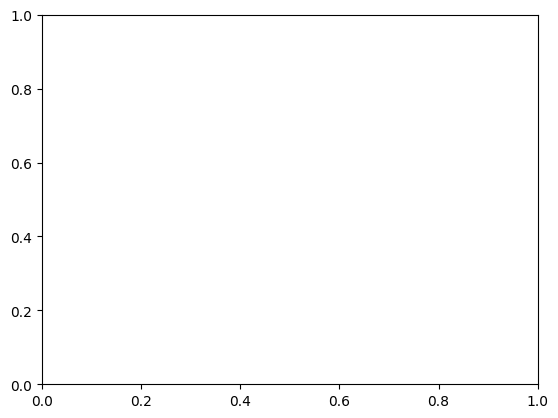

In [34]:
ax = plt.gca()

In [35]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [36]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(3392543, 2)

In [37]:
yhat_train.shape

(3392543, 2)

In [38]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [39]:
ytrain_single = np.argmax(ytrain, axis=1)

In [40]:
yhat_train_single.shape

(3392543,)

In [41]:
ytrain_single.shape

(3392543,)

In [42]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


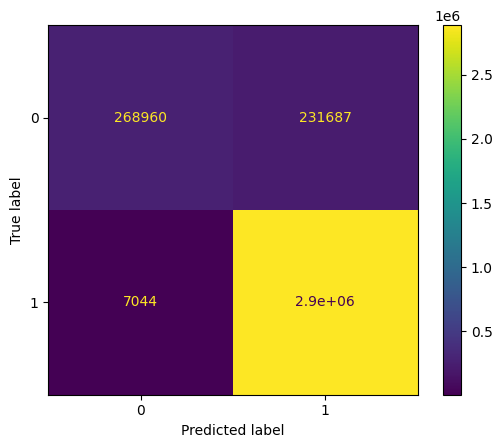

In [43]:
train_disp.plot()

In [44]:
ytest = np.round(ytest).astype(int)
ytest.shape

(1453948, 2)

In [45]:
yhat_test.shape

(1453948, 2)

In [46]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [47]:
ytest_single = np.argmax(ytest, axis=1)

In [48]:
yhat_test_single.shape

(1453948,)

In [49]:
ytest_single.shape

(1453948,)

In [50]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



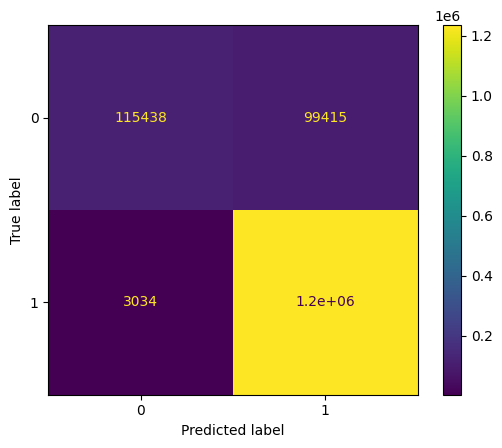

In [51]:
test_disp.plot()